In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import time

sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)
SEED = 1024


Segmentation Models: using `keras` framework.


In [3]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c], 448, 448, 3
def decode_crop(image, label):
    image = image[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]
    label = label[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)
    else:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds


In [4]:
def create_backbone_efficient():
    _backbone = keras.applications.EfficientNetB0(include_top=False)

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


In [5]:
class FPN(tf.keras.layers.Layer):
    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone_efficient()

        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=False)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)

        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN(backbone)
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


In [6]:
class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone_efficient()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_3 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_4 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(4, 4),
            padding="same",
            activation="relu",
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv1_o, conv2_o, conv3_o, conv4_o = self.backbone(images, training=False)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv4_o) + conv3_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv2_o
        fcn_4x = self.upscale2x_3(fcn_8x) + conv1_o
        final_output = self.upscale2x_4(fcn_4x)
        final_output = self.final_activation(final_output)
        return final_output


In [7]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def Jindex(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


def Dice(target, pred):
    intersection = tf.reduce_sum(2 * pred * target, [0, 1, 2])
    union = tf.reduce_sum(pred + target, [0, 1, 2])
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))

def Jindex_class(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return (intersection + 0.1) / (union + 0.1)



In [8]:
# pretrain_optimizer = tf.keras.optimizers.Adam()

# lr = 0.001 is good but spiky, next learning rate to test is 0.0005
# both fpn and unet uses 1e-4 learning rate

# test_fpn, lr = 0.00001 (1e-4)
# lr=1e-6, slow
# lr=1e-5, fast
# lr=5e-5, can trained but stagnate at 12k with iou of 0.69


In [9]:
# this iteration is calculated fom 160 iteration from
# paper

model_selection = ["fcn8s", "unet", "fpn"]
model_choice = 1
name_model = model_selection[model_choice]

n_classes = 8
batch_size = 8
trainds = create_ds(batch_size)
testds = create_ds(batch_size, False)

if model_choice == 0:
    model = FCN_ORIG(n_classes)
elif model_choice == 1:
    model = sm.Unet(
        backbone_name="efficientnetb0",
        encoder_weights="imagenet",
        encoder_freeze=False,
        activation="softmax",
        classes=n_classes,
        decoder_use_batchnorm=False,
    )
elif model_choice == 2:
    model = FCN(8)
else:
    assert "No model chosen"


focal_loss = sm.losses.CategoricalFocalLoss()
dice_loss = sm.losses.DiceLoss()

ckpt = tf.train.Checkpoint(model=model)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/{name_model}", 5)
ckptmg.restore_or_initialize()


2022-06-03 03:02:52.596544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:02:52.626704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:02:52.627136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:02:52.628117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

'trained_model/unet/ckpt-20'

In [11]:
ALPHA = 1.0

# testing on train dataset and testing dataset
iou_train = np.zeros([800, 8])
iou_test = np.zeros([280, 8])

# training set
print('Training set...')
time_init = time.time()
for idx, (bs_images, bs_labels) in trainds.enumerate():
    if model_choice == 1:
        bs_images = sm.get_preprocessing("efficientnetb0")(bs_images)
    output = model(bs_images, training=False)
    jindex = Jindex_class(bs_labels, output)
    iou_train[idx] = jindex
time_taken = time.time() - time_init
print(f'Time taken: {round(time_taken, 3)}s')
print(f'IoU: {round(np.average(iou_train), 3)}')

# testing set
print('Testing set...')
time_init = time.time()
for idx, (bs_images, bs_labels) in testds.enumerate():
    if model_choice == 1:
        bs_images = sm.get_preprocessing("efficientnetb0")(bs_images)
    output = model(bs_images, training=False)
    jindex = Jindex_class(bs_labels, output)
    iou_test[idx] = jindex
time_taken = time.time() - time_init
print(f'Time taken: {round(time_taken, 3)}s')
print(f'IoU: {round(np.average(iou_test), 3)}')

Training set...


2022-06-03 03:02:59.286732: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-03 03:03:03.078701: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-03 03:03:03.469200: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-03 03:03:03.544150: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

KeyboardInterrupt: 

<BarContainer object of 1 artists>

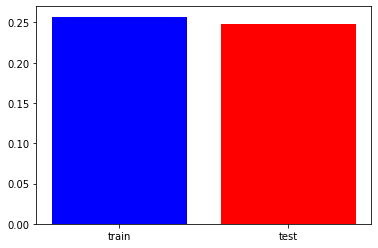

In [ ]:
plt.bar(x=['train'], height=[np.average(iou_train)], color='blue', align='center')
plt.bar(x=['test'], height=[np.average(iou_test)], color='red', align='center')

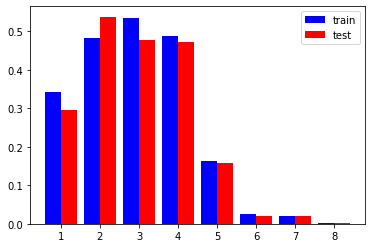

In [ ]:
plt.bar(
    x=[x + 1 for x in range(8)],
    height=np.average(iou_train, 0),
    color="blue",
    width=-0.4,
    align="edge",
    label='train'

)

plt.bar(
    x=[x + 1 for x in range(8)],
    height=np.average(iou_test, 0),
    color="red",
    width=0.4,
    align="edge",
    label='test'
)

plt.legend()

In [ ]:
def convert(x):
  return np.concatenate([[x[0]], x[1], x[2]])

results = pd.DataFrame(
    list(map(convert, [[name_model, np.average(iou_train, 0), np.average(iou_test, 0)]])),
    columns=[
        "model",
        "trainc1",
        "trainc2",
        "trainc3",
        "trainc4",
        "trainc5",
        "trainc6",
        "trainc7",
        "trainc8",
        "testc1",
        "testc2",
        "testc3",
        "testc4",
        "testc5",
        "testc6",
        "testc7",
        "testc8",
    ],
)
second = results.pop('model')

results.iloc[:, 0:] = results.iloc[:, 0:].astype('float')
results['model'] = second
results.to_csv(f'results_{name_model}.csv', index=False)